In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import models, transforms

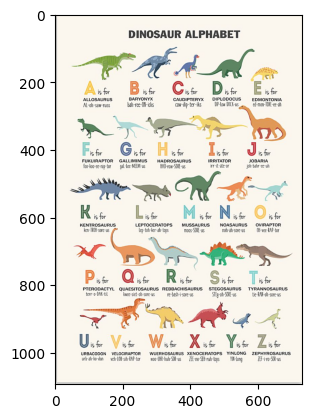

In [ ]:
image = cv2.imread('abc.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

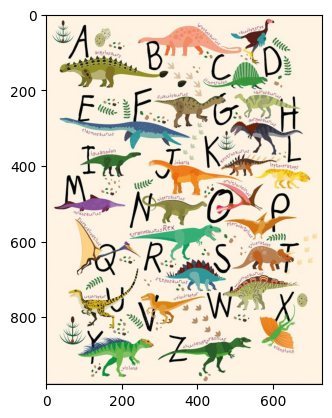

In [40]:
image_2 = cv2.imread('A_B_C.jpg')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
plt.imshow(image_2)
plt.show()

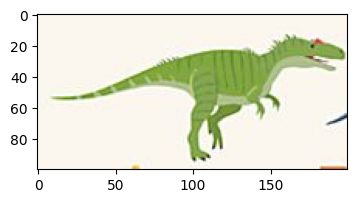

In [91]:
template = image[100:200, 40:240].copy()
plt.figure(figsize=(4, 4))
plt.imshow(template)
plt.show()

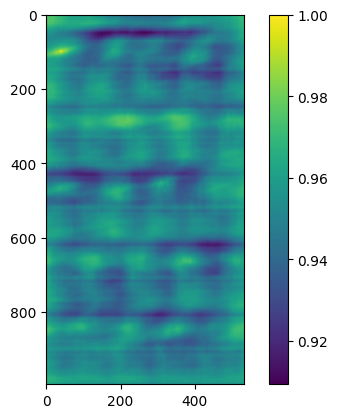

In [92]:
match = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
plt.imshow(match)#, cmap='hot')
plt.colorbar()
plt.show()

In [94]:
np.where(match == match.max()) # координаты "мэтча"

(array([100]), array([40]))

In [95]:
model = torchvision.models.resnet18(pretrained=True)
layer4_features = None
avgpool_emb = None

# define hooks
def get_features(module, inputs, output):
    global layer4_features
    layer4_features = output

def get_embedding(module, inputs, output):
    global avgpool_emb
    avgpool_emb = output

model.layer4.register_forward_hook(get_features)
model.avgpool.register_forward_hook(get_embedding)
model.eval()

c:\conda\envs\osnov\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\conda\envs\osnov\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [97]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

template_tensor = preprocess(template).unsqueeze(0)

with torch.no_grad():
    model(template_tensor)

template_emb = avgpool_emb.squeeze(0).numpy()

In [98]:
image_2_tensor = preprocess(image_2).unsqueeze(0)

with torch.no_grad():
    model(image_2_tensor)
    
# НЕ делаем .numpy() пока!
features = layer4_features[0]  # [512, H, W], это тензор

C, H, W = features.shape

# flatten spatial map
features_flat = features.view(C, -1).T  # [H*W, 512]


In [99]:

# нормализация
features_norm = torch.nn.functional.normalize(features_flat, dim=1)
template_emb_norm = torch.nn.functional.normalize(template_emb, dim=0)  # [512]

# косинусное сходство
cos_sim = torch.matmul(features_norm, template_emb_norm)  # [H*W]
heatmap = cos_sim.view(H, W).cpu().numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'norm'

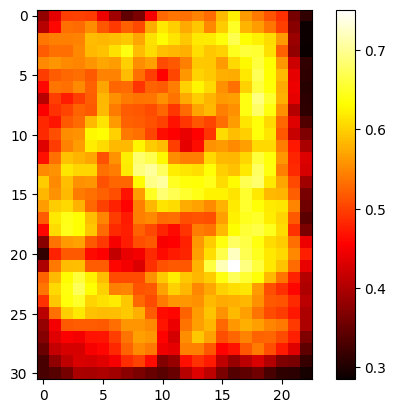

In [88]:
plt.imshow(heatmap, cmap='hot')
plt.colorbar()
plt.show()


Template найден в точке: x=16, y=21


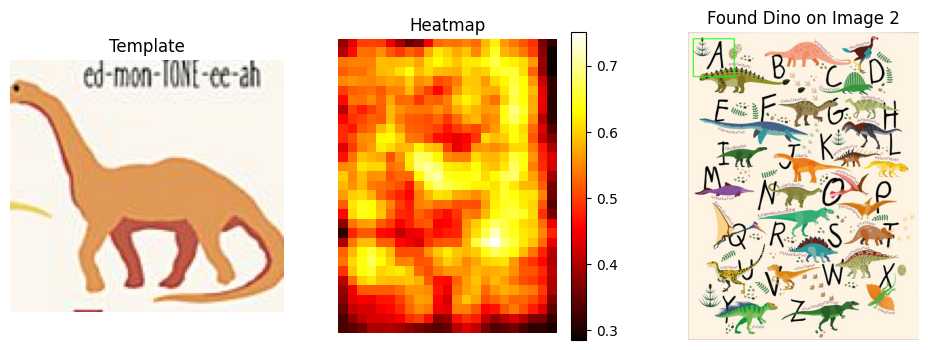

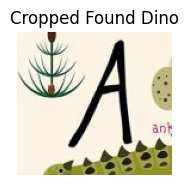

In [89]:
# 5. координаты максимума
y, x = divmod(heatmap.argmax(), W)
print(f"Template найден в точке: x={x}, y={y}")

# 6. размер шаблона
h, w = template.shape[:2]

# 7. рисуем прямоугольник на втором изображении
img_draw = image_2.copy()
cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)

# 8. вырезаем найденный участок
found_patch = image_2[y:y+h, x:x+w].copy()

# 9. визуализация
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Template")
plt.imshow(template)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='hot')
plt.colorbar()
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Found Dino on Image 2")
plt.imshow(img_draw)
plt.axis('off')

plt.show()

# дополнительно можно вывести сам найденный участок
plt.figure(figsize=(2,2))
plt.title("Cropped Found Dino")
plt.imshow(found_patch)
plt.axis('off')
plt.show()